In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [4]:
np.random.seed(42)

# Cargamos los datos
df_housing = pd.read_csv("./data/housing.csv")

# Creamos nuestro atributo categórico para los ingresos
df_housing["income_cat"] = pd.cut(df_housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

# Dividimos los datos en conjunto de entrenamiento y prueba
strat_train_set, strat_test_set = train_test_split(df_housing, test_size=0.2, stratify=df_housing["income_cat"], random_state=42)

# Eliminamos la categoria income_cat de ambos conjuntos porque no la usamos
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Separamos predictores y etiquetas
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# Prepación de los Datos usando transformers

implementar funciones para la transformación de los datos es muy útil.


In [5]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])


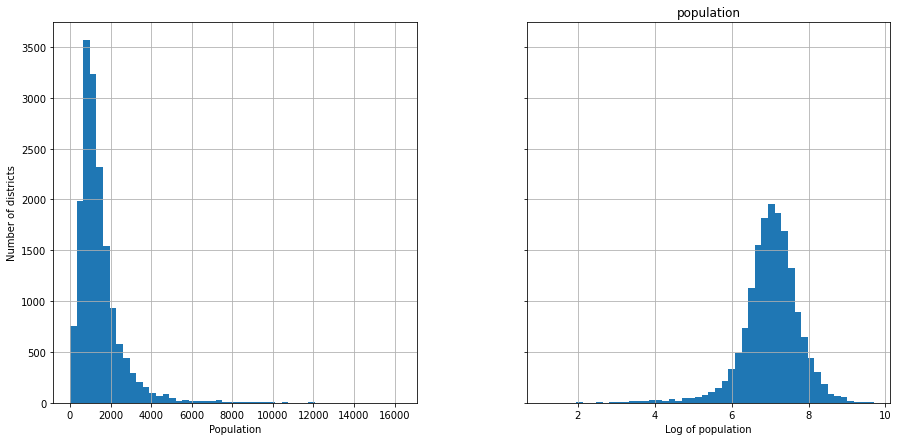

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

housing["population"].hist(ax=axs[0], bins=50)
log_pop.hist(ax=axs[1], bins=50)

axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")

plt.show()

Pero ¿qué sucede si deseas que tu transformador sea entrenable, es decir, que aprenda algunos parámetros en el método `fit()` y los use más tarde en el método `transform()`? Para esto, necesitas escribir una clase personalizada. Scikit-Learn se basa en duck typing, por lo que esta clase no tiene que heredar de ninguna clase base en particular. Lo único que necesita son tres métodos: `fit()` (que debe devolver `self`), `transform()` y `fit_transform()`.

Se puede tener el método `fit_transform()` simplemente agregando `TransformerMixin` como una clase base: la implementación predeterminada simplemente llamará a `fit()` y luego a `transform()`. Si agregas `BaseEstimator` como una clase base, también obtendrás dos métodos adicionales: `get_params()` y `set_params()`. Estos serán útiles para ajustar hiperparámetros.

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y es requerido aunque no se usa
        X = check_array(X)  # verifica que X es un array con valores flotantes finitos
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # esta información se guarda en fit
        return self  # siempre debe retornar self!

    def transform(self, X):
        check_is_fitted(self)  # se fija en los atributos entrenados (con _ al final)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

## Pipelines

### Implementemos un pipeline para procesar los datos numéricos

In [8]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")), # los nombres deben ser únicos y no tener __ (dobles guiones bajos)
    ("standardize", StandardScaler()),
])
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

Los componentes deben ser transformers (tener el método `fit_transform()`) excepto el último que debe tener el método `fit()`.

Cuando llamas al método `fit()` del pipeline, este llama secuencialmente a `fit_transform()` en todos los transformadores, pasando la salida de cada llamada como parámetro a la siguiente llamada hasta llegar al estimador final, para el cual simplemente llama al método `fit()`.

El pipeline expone los mismos métodos que el estimador final. En este ejemplo, el último estimador es un `StandardScaler`, que es un transformador, por lo que el pipeline también actúa como un transformador. Si llamamos al método `transform()` del pipeline, aplicará secuencialmente todas las transformaciones a los datos. 

Si el último estimador fuera un predictor en lugar de un transformador, entonces el pipeline tendrá un método `predict()` en lugar de `transform()`. Llamar a este método aplicaría secuencialmente todas las transformaciones a los datos y pasaría el resultado al método `predict()` del predictor.

In [9]:
housing_num = housing.drop("ocean_proximity", axis=1)

housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [10]:
num_pipeline.get_feature_names_out()

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [11]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)
df_housing_num_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365
...,...,...,...,...,...,...,...,...
14207,0.586397,-0.833359,0.987087,-0.184147,0.140152,-0.445315,0.060101,0.444041
13105,0.131525,0.319822,-0.443146,0.139847,0.128298,-0.005950,0.083608,-0.685630
19301,1.256209,-1.428701,-1.237721,0.586026,0.562134,1.268299,0.679135,0.101049
19121,0.586397,-0.739605,0.669257,0.522417,0.794461,0.273563,0.882868,0.145396


### Mejor implementar un transformer que aplique las transformaciones necesarias a columnas numéricas y categóricas

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

cat_pipeline = make_pipeline( 
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

Otra forma de escribir el transformer anterior sin listar todos los nombres de las columnas y sin nombrar los transformers

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

cat_pipeline = make_pipeline( 
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

Ahora si, apliquemos nuestro transformer!! 

In [14]:
housing_prepared = preprocessing.fit_transform(housing)

In [15]:
housing_prepared_df = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)

housing_prepared_df.head()

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789,0.0,1.0,0.0,0.0,0.0
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281,0.0,1.0,0.0,0.0,0.0
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365,0.0,0.0,0.0,0.0,1.0


In [16]:
housing_prepared_df.shape

(16512, 13)

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

cat_pipeline = make_pipeline( 
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))


log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())


preprocessing_2 = ColumnTransformer(
    [
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=num_pipeline
    
    )

In [18]:
housing_prepared_2 = preprocessing_2.fit_transform(housing)

In [19]:
housing_prepared_df_2 = pd.DataFrame(
    housing_prepared_2,
    columns=preprocessing_2.get_feature_names_out(),
    index=housing.index)

housing_prepared_df_2.head()

,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__longitude,remainder__latitude,remainder__housing_median_age
13096,1.324114,0.637892,0.456906,1.310369,-1.071522,0.0,0.0,0.0,1.0,0.0,-1.423037,1.013606,1.861119
14973,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,1.0,0.0,0.0,0.0,0.0,0.596394,-0.702103,0.907630
3785,-0.925266,-0.859927,-0.941997,-0.913030,-0.756981,0.0,1.0,0.0,0.0,0.0,-1.203098,1.276119,0.351428
14689,0.952773,0.943475,0.670700,0.925373,-0.912253,0.0,1.0,0.0,0.0,0.0,1.231216,-0.884924,-0.919891
20507,1.437622,1.003590,0.719093,1.481464,0.034537,0.0,0.0,0.0,0.0,1.0,0.711362,-0.875549,0.589800
